# Import Libraries

In [18]:
!pip install pydot
!pip install graphviz
!pip install wordcloud spacy scikit-learn pandas matplotlib seaborn
!pip install numpy==1.26.1

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [21]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
from keras.layers import TextVectorization
from keras.utils import pad_sequences

In [23]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [24]:
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk

In [25]:
# Method to plot models accuracy/loss

def plot_history(history):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Load the Dataset and Prepare the data

In [26]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')
print('No. of rows and columns :', df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No. of rows and columns : (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [27]:
import spacy
import pandas as pd
from tqdm import tqdm
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])  # Disable components we don't need

# Define a function to process a single review
def normalize_single_review(doc, lowercase=True, remove_stopwords=True):
    lemmatized = []
    for token in doc:
        lemma = token.lemma_.lower() if lowercase else token.lemma_
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(lemma)
    return " ".join(lemmatized)

# Process the dataset in chunks
def process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True):
    results = []

    for i in tqdm(range(0, len(df), chunk_size)):  # Loop through the dataset in chunks
        chunk = df['review'].iloc[i:i+chunk_size].tolist()

        # Process each chunk using spaCy's pipe for efficiency
        processed_chunk = []
        for doc in nlp.pipe(chunk, batch_size=batch_size, n_process=1):  # Use a limited number of processes
            processed_chunk.append(normalize_single_review(doc, lowercase=lowercase, remove_stopwords=remove_stopwords))

        results.extend(processed_chunk)  # Add the processed chunk to results

    return results

In [28]:
#methods from nltk
# to remove non alphanumeric character
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [29]:
# apply preprocessing steps
df['review'] = df['review'].apply(remove_URL)
print("remove_URL function done")
df['review'] = df['review'].apply(remove_html)
print("remove_html function done")
df['review'] = df['review'].apply(alpha_num)
print("alpha_num function done")
# Apply the chunked processing to the entire dataframe
# df['review'] = df['review'].apply(normalize,lowercase=True, remove_stopwords=True)
df['preview'] = process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True)

# Display the processed dataframe
df.head()

remove_URL function done
remove_html function done
alpha_num function done


100%|██████████| 50/50 [12:43<00:00, 15.27s/it]


,review,sentiment,preview
0,One of the other reviewers has mentioned that ...,positive,reviewer mention watch 1 oz episode ll hook ri...
1,A wonderful little production The filming tech...,positive,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...
3,Basically theres a family where a little boy J...,negative,basically s family little boy jake think s zom...
4,Petter Matteis Love in the Time of Money is a ...,positive,petter matteis love time money visually stunni...


In [30]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['sentiment'])
df['labels'] = label_encoder.transform(df['sentiment'])

In [31]:
# train-test split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df['preview'], df['labels'], test_size=0.2, random_state=5, stratify=df['labels'])

## Prepare the data for Deep Learning models

- **TextVectorization**:https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

> A preprocessing layer which maps text features to integer sequences.

> This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one example = one string) into either a list of token indices (one example = 1D tensor of integer token indices) or a dense representation (one example = 1D tensor of float values representing data about the example's tokens). This layer is meant to handle natural language inputs. To handle simple string inputs (categorical strings or pre-tokenized strings) see kers_core.layers.StringLookup.

> The vocabulary for the layer must be either supplied on construction or learned via adapt(). When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

> The processing of each example contains the following steps:

+ Standardize each example (usually lowercasing + punctuation stripping)

+ Split each example into substrings (usually words)

+ Index tokens (associate a unique int value with each token)

+ Transform each example using this index, either into a vector of ints or a dense float vector.


In [32]:
# Model Parameters
embedding_dim = 100  # Size of the word embedding vectors
max_length = 100  # Maximum length of input sequences (for padding/truncation)
trunc_type = 'post'  # Truncate sequences from the end if they exceed max_length
padding_type = 'post'  # Pad sequences at the end if they are shorter than max_length

# Define Vocabulary Size
vocab_size = 20000  # Limit vocabulary size to 20,000 words
oov_token = "<OOV>"  # Token for out-of-vocabulary words (OOV handling)

# Create a TextVectorization Layer
vectorizer = TextVectorization(
    max_tokens=vocab_size,  # Define vocabulary size
    output_mode="int"  # Convert words into integer sequences
)

# Adapt the vectorizer to the training dataset (build vocabulary from training sentences)
vectorizer.adapt(train_sentences)

train_sequences = vectorizer(tf.constant(train_sentences))
test_sequences = vectorizer(tf.constant(test_sentences))

# Retrieve vocabulary and create a word index mapping (word → integer ID)
vocab = vectorizer.get_vocabulary()
word_index = {word: idx for idx, word in enumerate(vocab)}

# Get the actual vocabulary size (including OOV and mask tokens)
vocab_size = vectorizer.vocabulary_size()
print("Vocabulary size including optional mask and OOV indices is: ", vocab_size)

Vocabulary size including optional mask and OOV indices is:  20000


- **pad_sequences**: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

> This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

> Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.

> Sequences longer than num_timesteps are truncated so that they fit the desired length.

> The position where padding or truncation happens is determined by the arguments padding and truncating, respectively. Pre-padding or removing values from the beginning of the sequence is the default.

In [33]:
# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# convert validation dataset to sequence and pad sequences
test_sequences = vectorizer(tf.constant(test_sentences))
test_padded = pad_sequences(test_sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)

In [34]:
print(vocab_size)

20000


In [35]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Download the Pretrained Glove Embedding

In [38]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2025-02-18 17:11:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-18 17:11:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-18 17:11:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [39]:
# Define the path to the pre-trained GloVe embeddings file
EMBEDDING_FILE = 'glove.6B.100d.txt'  # Change file name if using a different GloVe version

# Initialize an empty dictionary to store word embeddings
word_vectors = {}

# Open the GloVe file and read the embeddings
with open(EMBEDDING_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()  # Split each line into word + embedding values
        word = values[0]  # The first value in the line is the word
        coefs = np.asarray(values[1:], dtype='float32')  # The remaining values are the embedding coefficients
        word_vectors[word] = coefs  # Store the word and its corresponding embedding in the dictionary


In [40]:
# Initialize an embedding matrix with zeros
# Shape: (vocab_size + 1, embedding_dim)
#   - vocab_size + 1: Extra row for padding index (zero index)
#   - embedding_dim: Each word vector's dimension (e.g., 100 for GloVe 100D)
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Iterate over the word_index dictionary (word → integer mapping)
for word, i in word_index.items():
    # Retrieve the pre-trained embedding vector for the word
    embedding_vector = word_vectors.get(word)
    # If the word exists in GloVe embeddings, store its vector in the matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Assign the vector to its corresponding index


# Build a GRU model with Pre-trained Glove Embedding

In [41]:
from keras.layers import Input, Embedding, GRU, Dense

# Ensure these variables are defined correctly
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe word vectors (e.g., 50, 100, 300)
# max_length: Maximum length of input sequences
# embedding_matrix: Pre-trained GloVe embeddings (shape: (vocab_size, embedding_dim))

# Define input layer (1D input for sequences)
input_layer = Input(shape=(max_length,))  # Matches input_length in Embedding

# Embedding layer using pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze embeddings (prevent updates)
)(input_layer)

# GRU layer (receives input of shape (batch_size, max_length, embedding_dim))
gru_layer = GRU(64, return_sequences=False)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(gru_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,033,557 (7.76 MB)

 Trainable params: 33,457 (130.69 KB)

 Non-trainable params: 2,000,100 (7.63 MB)


### EarlyStopping: https://keras.io/api/callbacks/early_stopping/

> Stop training when a monitored metric has stopped improving.

> Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

> The quantity to be monitored needs to be available in logs dict. To make it so, pass the loss or metrics at model.compile().



* **monitor**: Quantity to be monitored.
* **min_delta**: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* **patience**: Number of epochs with no improvement after which training will be stopped.
* **verbose**: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
* **mode**: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
* **baseline**: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
* **restore_best_weights**: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.
* **start_from_epoch**: Number of epochs to wait before starting to monitor improvement. This allows for a warm-up period in which no improvement is expected and thus training will not be stopped.

In [42]:
# fit model
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

# num_epochs = 50
num_epochs=50
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)


Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5801 - loss: 0.6491 - val_accuracy: 0.8026 - val_loss: 0.4429
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8217 - loss: 0.4003 - val_accuracy: 0.8310 - val_loss: 0.3787
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8429 - loss: 0.3598 - val_accuracy: 0.8383 - val_loss: 0.3643
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8552 - loss: 0.3373 - val_accuracy: 0.8422 - val_loss: 0.3593
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8693 - loss: 0.3082 - val_accuracy: 0.8438 - val_loss: 0.3606
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8829 - loss: 0.2812 - val_accuracy: 0.8508 - val_loss: 0.3488
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8932 - loss: 0.2611 - val_accuracy: 0.8525 - val_loss: 0.3498
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9070 - loss: 0.2306 - val_accurac

In [43]:
!pip install pydot graphviz
import pydot

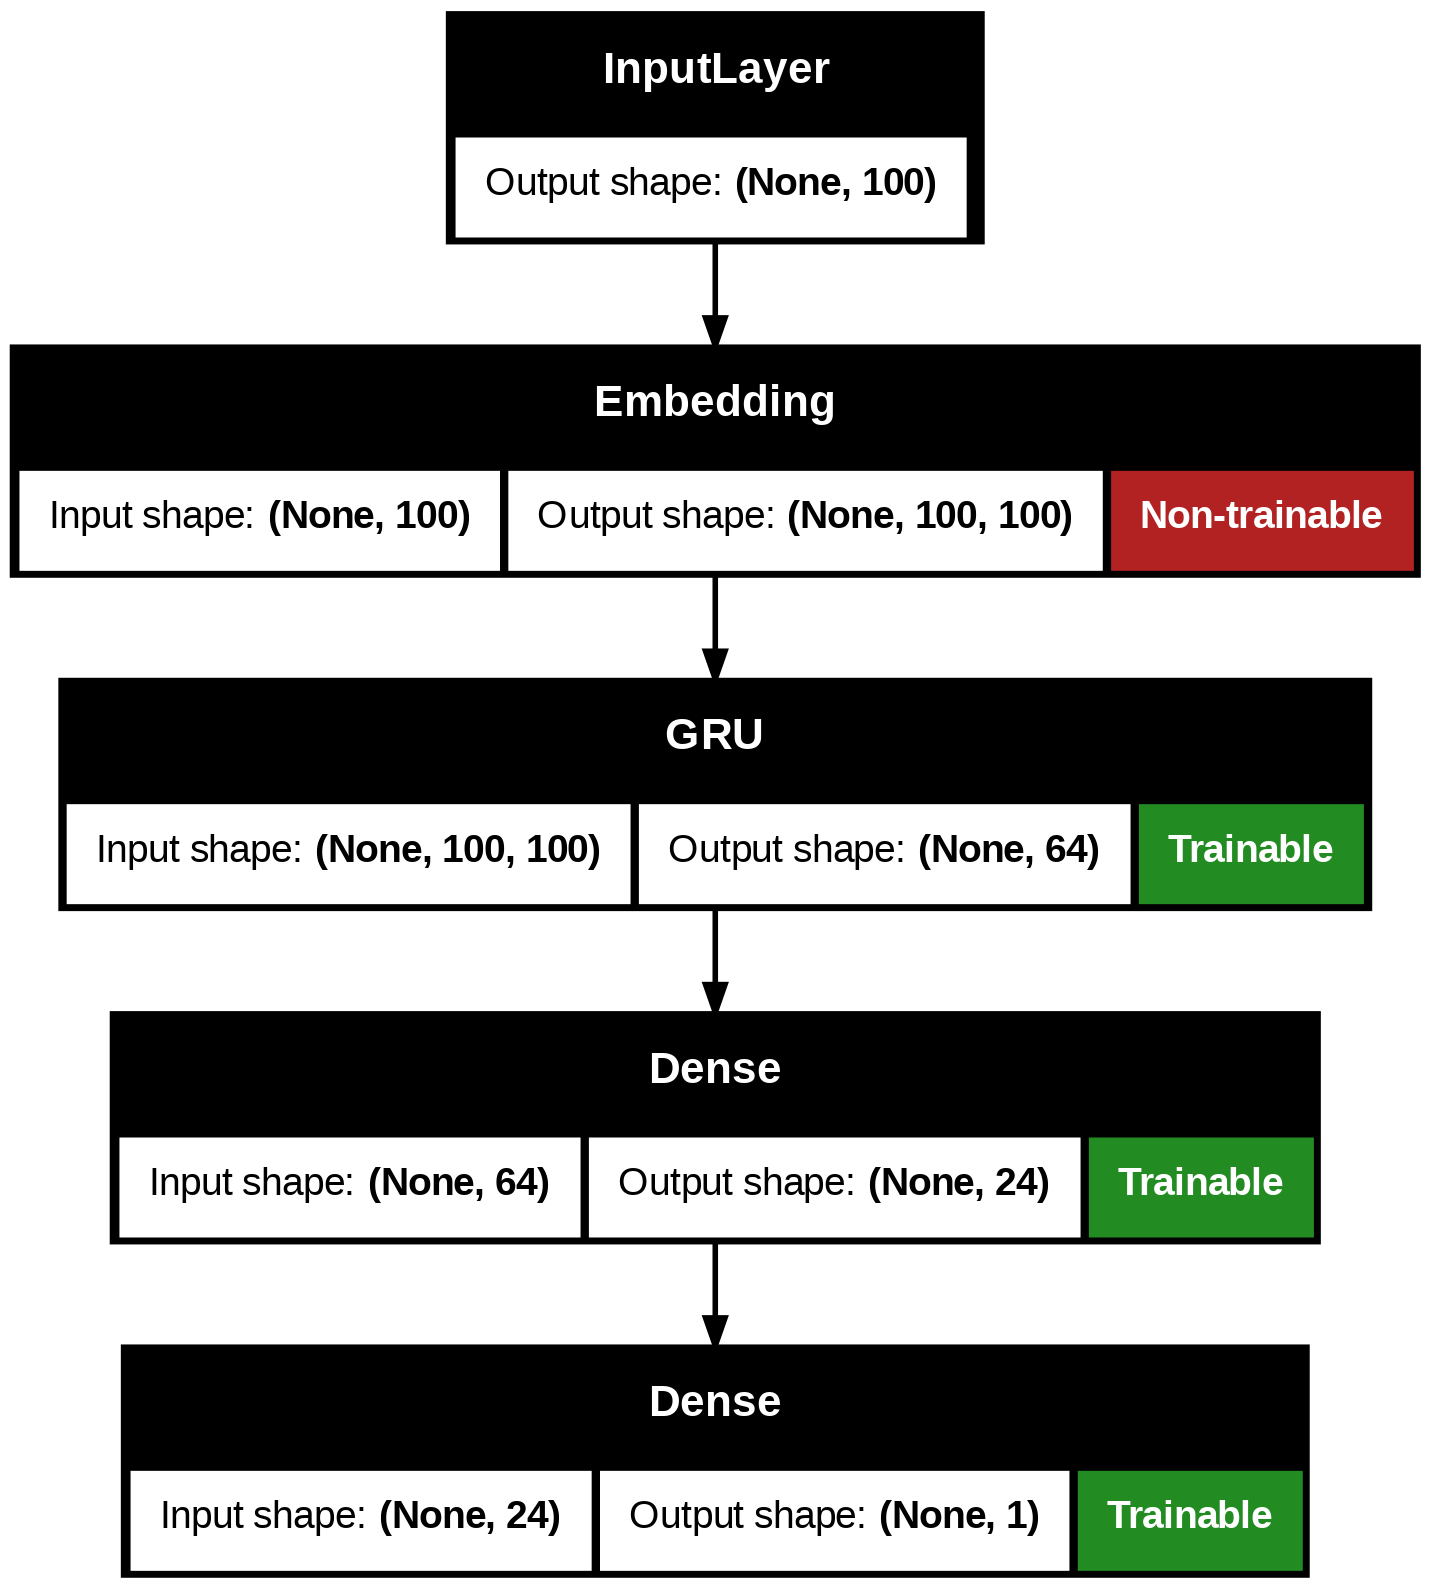

In [44]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_trainable=True)

In [45]:
results = model.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8528 - loss: 0.3441


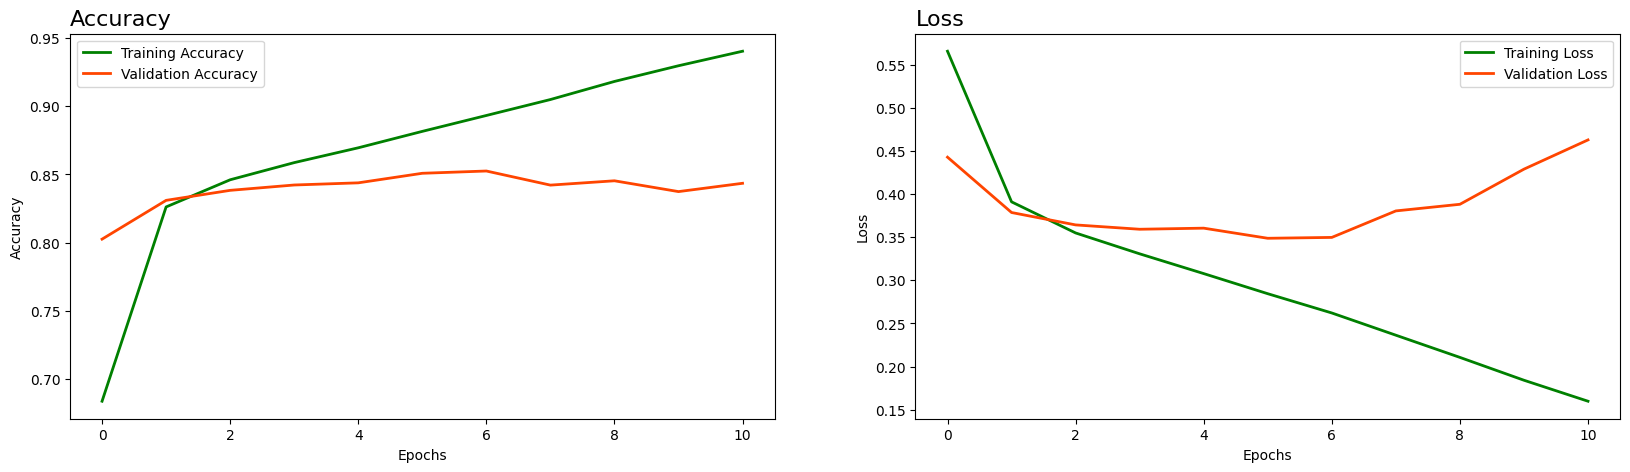

In [46]:
plot_history(history)

In [47]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5000
           1       0.84      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



# Build an LSTM model with Pre-trained Glove Embeddings

In [48]:
from keras.layers import Input, Embedding, LSTM, Dense

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze GloVe embeddings (set True for fine-tuning)
)(input_layer)

# LSTM layer
lstm_layer = LSTM(64)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the Functional model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,043,925 (7.80 MB)

 Trainable params: 43,825 (171.19 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

In [49]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5851 - loss: 0.6644 - val_accuracy: 0.5178 - val_loss: 0.6887
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5982 - loss: 0.6548 - val_accuracy: 0.6236 - val_loss: 0.6544
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6136 - loss: 0.6502 - val_accuracy: 0.8011 - val_loss: 0.4409
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8083 - loss: 0.4271 - val_accuracy: 0.8212 - val_loss: 0.3979
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8271 - loss: 0.3861 - val_accuracy: 0.8302 - val_loss: 0.3824
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8392 - loss: 0.3665 - val_accuracy: 0.8319 - val_loss: 0.3752
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8476 - loss: 0.3507 - val_accuracy: 0.8233 - val_loss: 0.3921
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8573 - loss: 0.3338 - val_ac

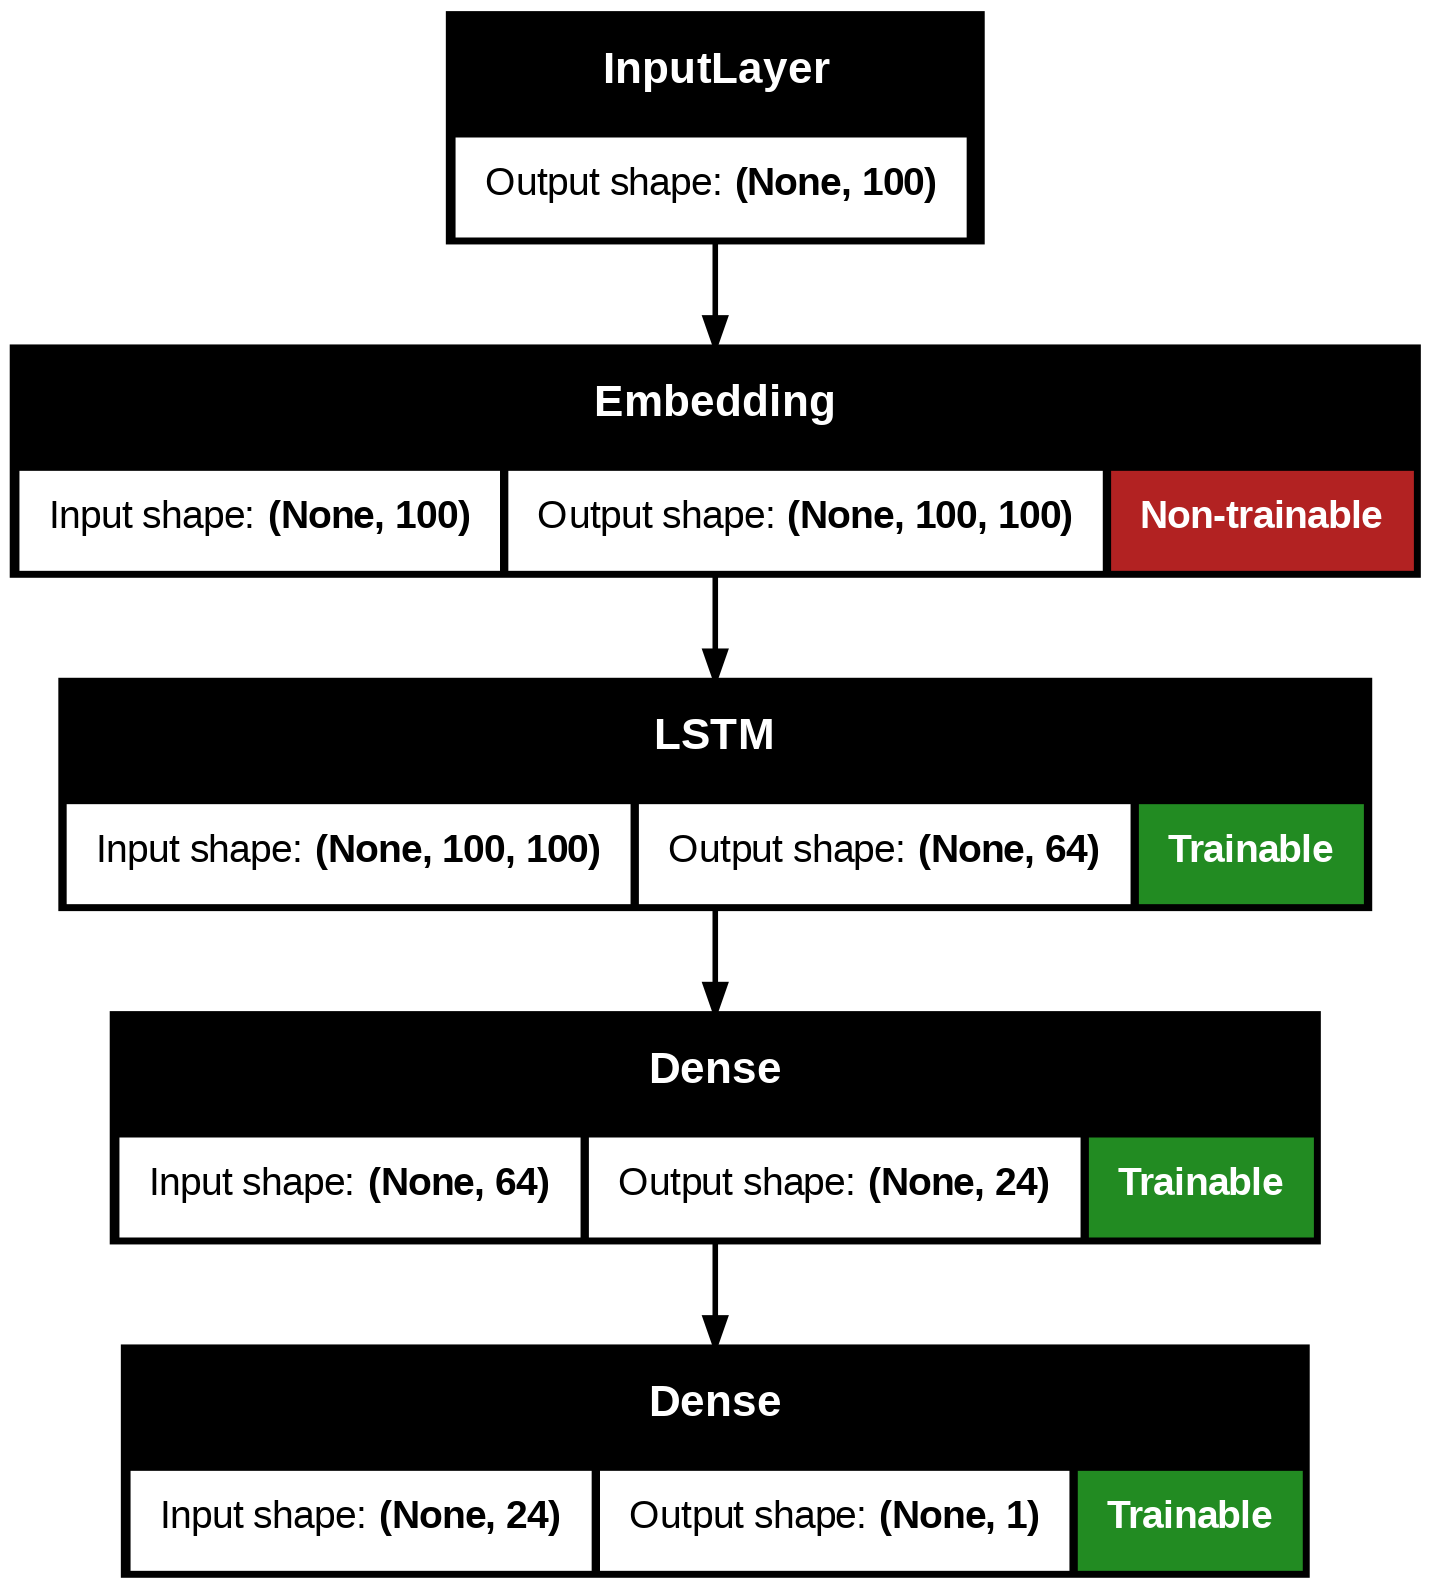

In [50]:
plot_model(model, show_shapes=True, show_trainable = True)

In [51]:
results = model.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8371 - loss: 0.3682


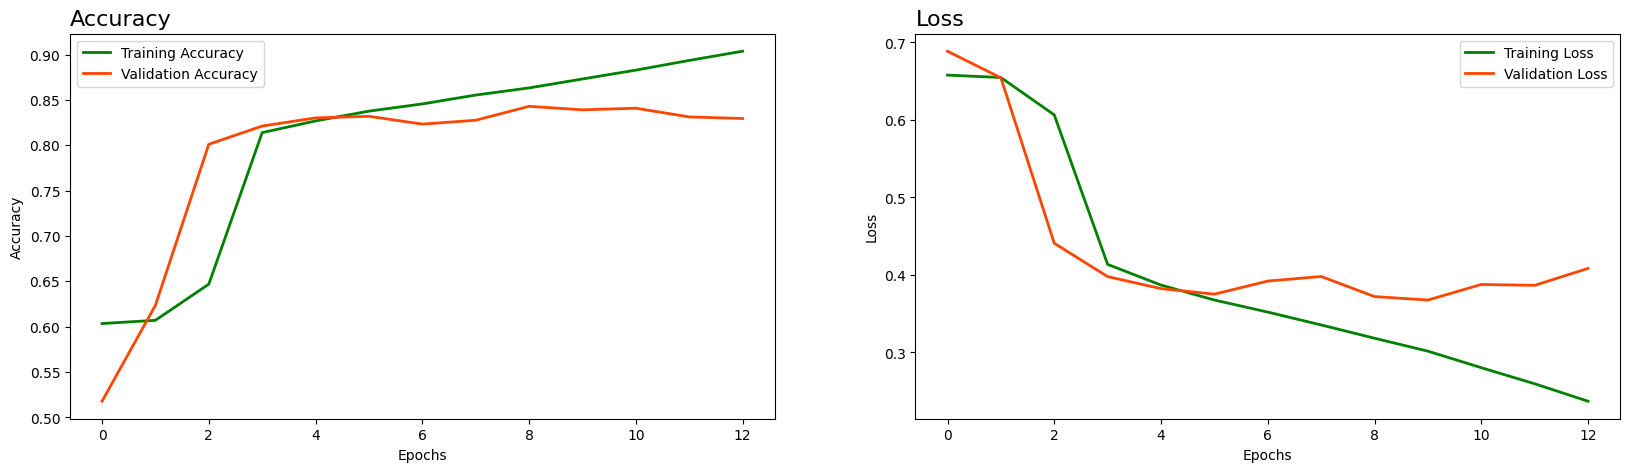

In [52]:
plot_history(history)

In [53]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      5000
           1       0.85      0.81      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



# Build a Sentiment Classification Model with Element wise Mean of All Hidden States

In [54]:
from keras.layers import Input, Embedding, LSTM, Dense, GlobalAveragePooling1D

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze GloVe embeddings (set True for fine-tuning)
)(input_layer)

# LSTM layer with return_sequences=True to retain all hidden states
lstm_layer = LSTM(64, return_sequences=True)(embedding_layer)

# Apply GlobalAveragePooling1D to take the element-wise mean across all time steps
mean_hidden_states = GlobalAveragePooling1D()(lstm_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(mean_hidden_states)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the Functional model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,043,925 (7.80 MB)

 Trainable params: 43,825 (171.19 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

In [55]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7289 - loss: 0.5348 - val_accuracy: 0.8136 - val_loss: 0.4099
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8227 - loss: 0.3948 - val_accuracy: 0.8275 - val_loss: 0.3816
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8469 - loss: 0.3490 - val_accuracy: 0.8363 - val_loss: 0.3707
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8572 - loss: 0.3354 - val_accuracy: 0.8426 - val_loss: 0.3685
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8655 - loss: 0.3127 - val_accuracy: 0.8446 - val_loss: 0.3613
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8745 - loss: 0.2965 - val_accuracy: 0.8478 - val_loss: 0.3513
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8848 - loss: 0.2754 - val_accuracy: 0.8372 - val_loss: 0.3723
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8951 - loss: 0.2568 - val_accuracy

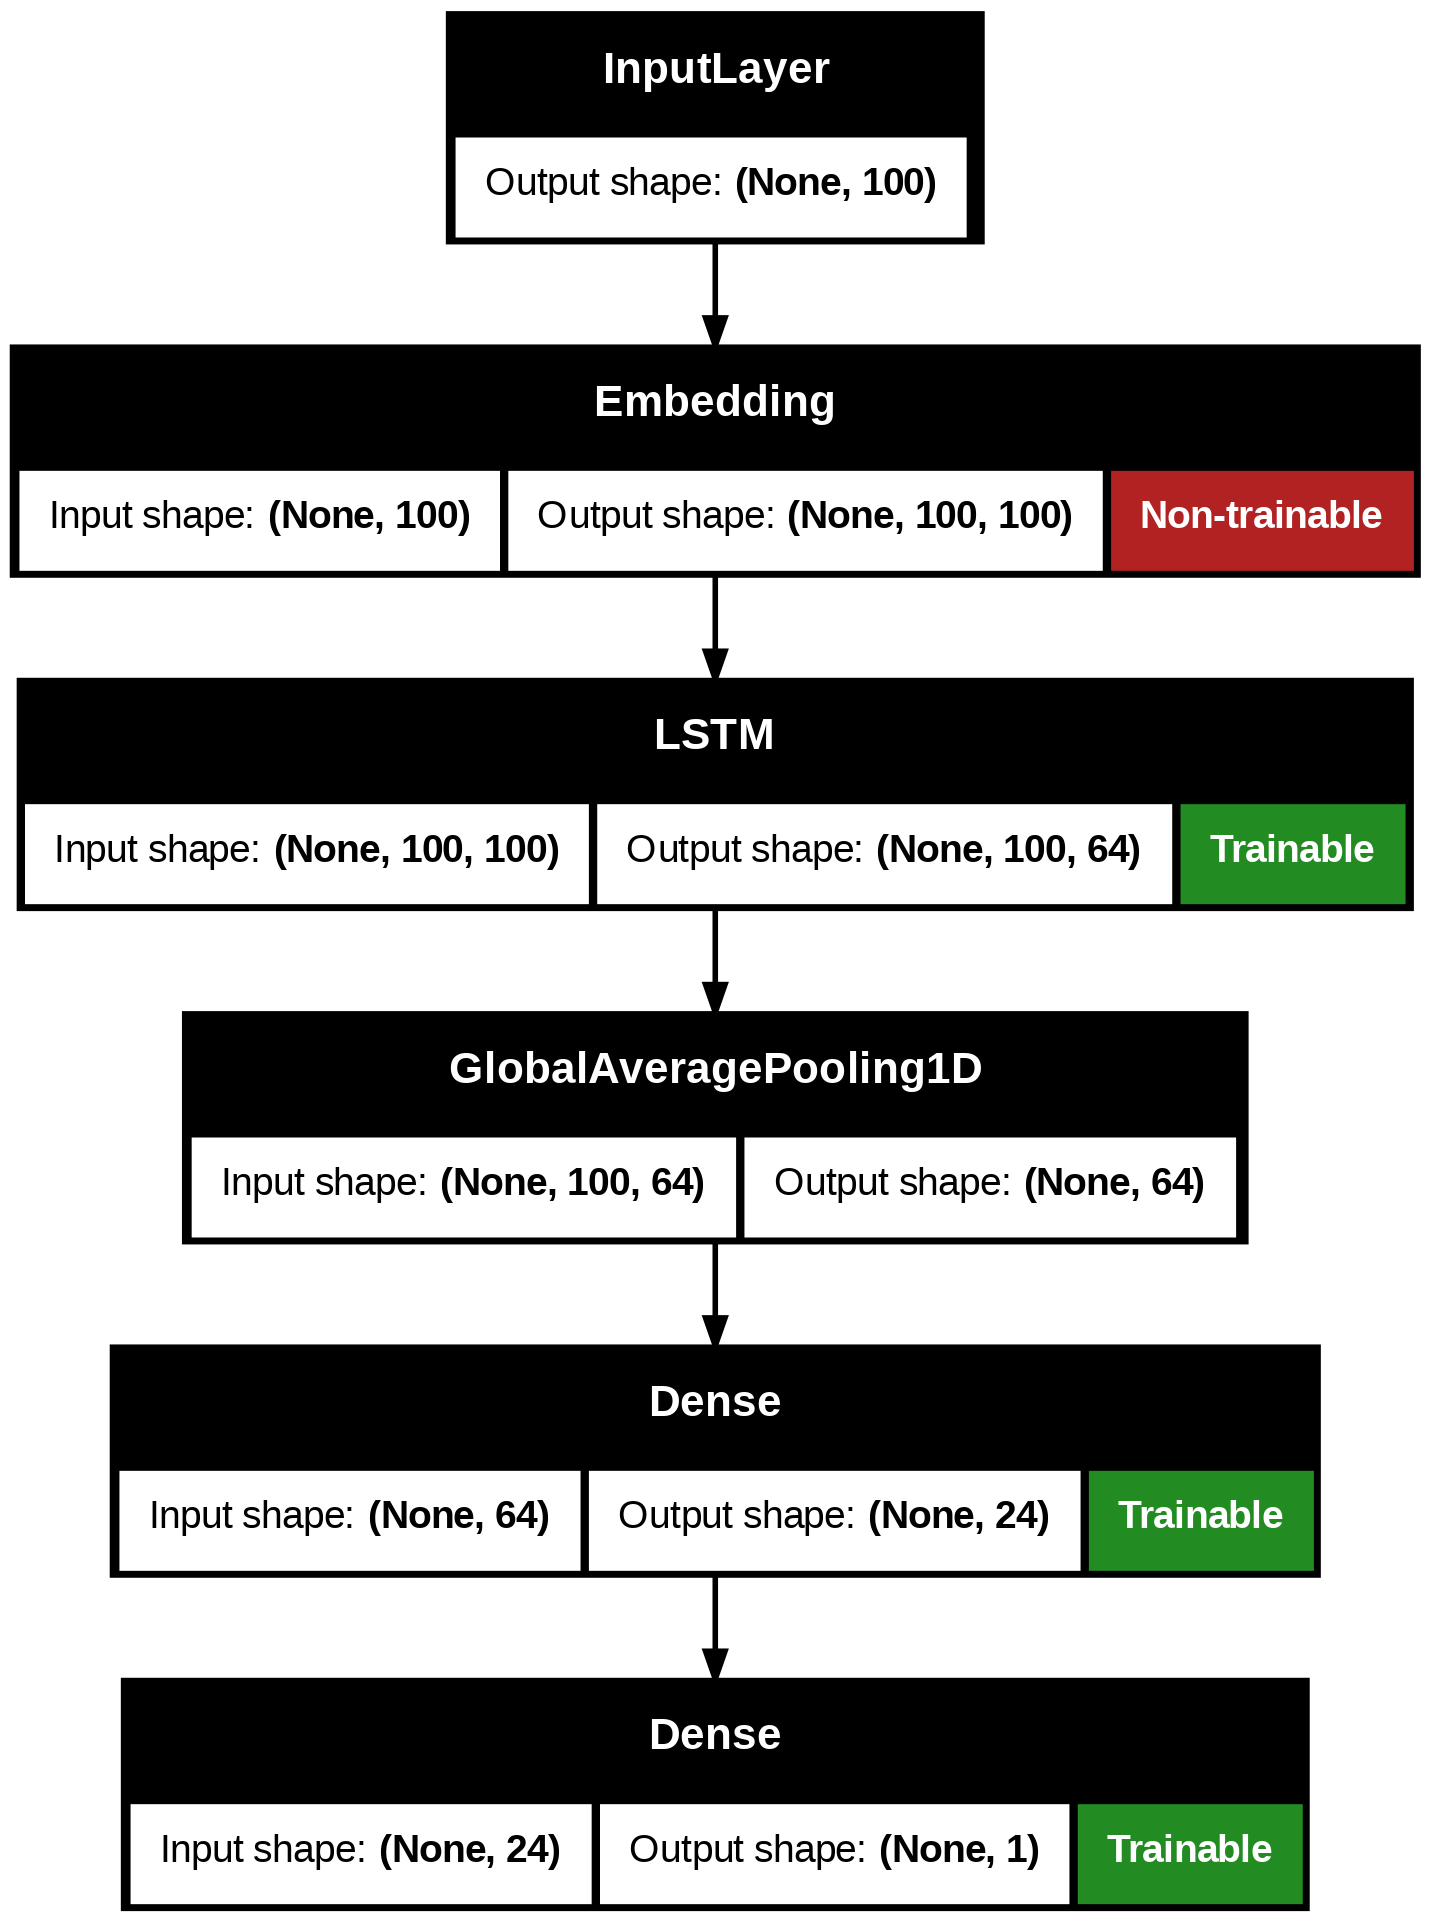

In [56]:
plot_model(model, show_shapes=True, show_trainable = True)

In [57]:
results = model.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8527 - loss: 0.3482


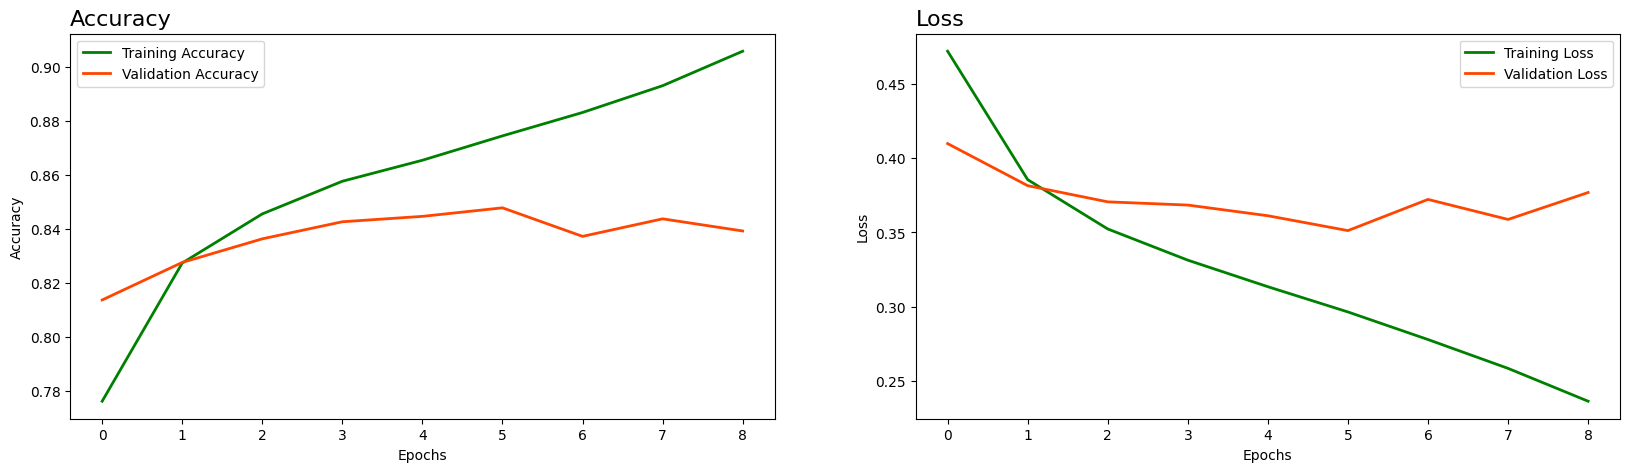

In [58]:
plot_history(history)

In [59]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5000
           1       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



# Build a GRU Model with Trainable word embeddings - Glove

In [60]:
from keras.layers import Input, Embedding, GRU, Dense

# Ensure these variables are defined correctly
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe word vectors (e.g., 50, 100, 300)
# max_length: Maximum length of input sequences
# embedding_matrix: Pre-trained GloVe embeddings (shape: (vocab_size, embedding_dim))

# Define input layer (1D input for sequences)
input_layer = Input(shape=(max_length,))  # Matches input_length in Embedding

# Embedding layer using pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=True                # Update embeddings
)(input_layer)

# GRU layer (receives input of shape (batch_size, max_length, embedding_dim))
gru_layer = GRU(64, return_sequences=False)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(gru_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,033,557 (7.76 MB)

 Trainable params: 2,033,557 (7.76 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

num_epochs = 50
# num_epochs=2
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5370 - loss: 0.6758 - val_accuracy: 0.8453 - val_loss: 0.3512
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8745 - loss: 0.2974 - val_accuracy: 0.8610 - val_loss: 0.3229
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9379 - loss: 0.1728 - val_accuracy: 0.8677 - val_loss: 0.3368
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9741 - loss: 0.0814 - val_accuracy: 0.8618 - val_loss: 0.4125
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9918 - loss: 0.0314 - val_accuracy: 0.8565 - val_loss: 0.5643
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9962 - loss: 0.0166 - val_accuracy: 0.8506 - val_loss: 0.7011
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9977 - loss: 0.0103 - val_accuracy: 0.8556 - val_loss: 0.7660


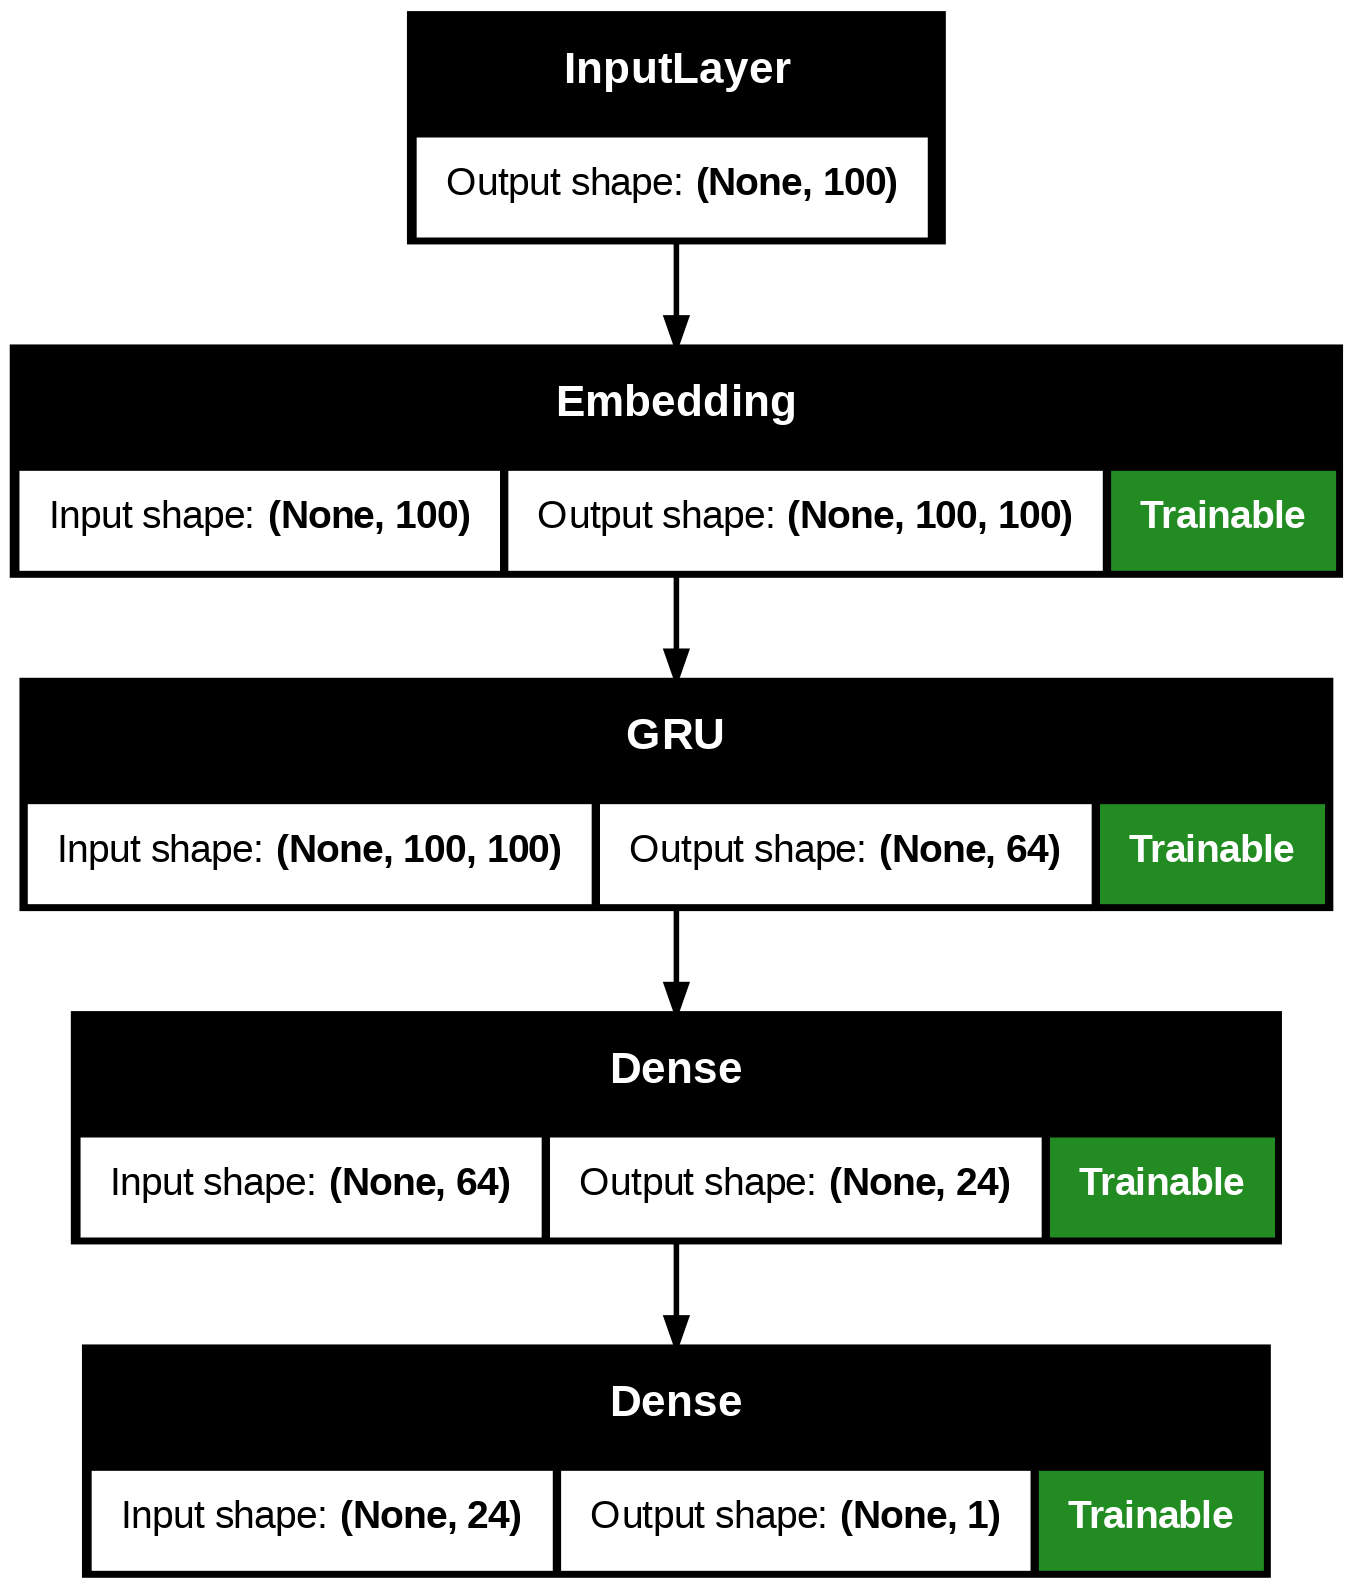

In [62]:
tf.keras.utils.plot_model(model, show_shapes=True, show_trainable = True)

In [63]:
results = model.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8497 - loss: 0.3302


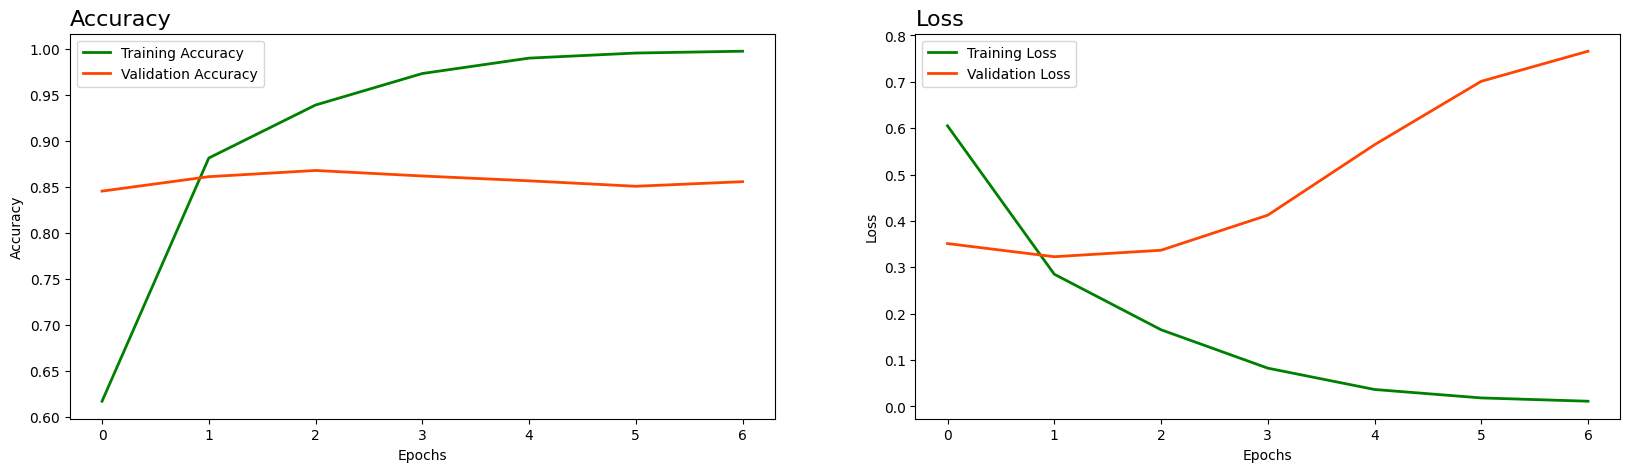

In [64]:
plot_history(history)

In [65]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      5000
           1       0.91      0.79      0.84      5000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



# Build an LSTM model with trainable embeddings - Glove

In [66]:
from keras.layers import Input, Embedding, LSTM, Dense

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=True                 # set True for fine-tuning
)(input_layer)

# LSTM layer
lstm_layer = LSTM(64)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the Functional model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,043,925 (7.80 MB)

 Trainable params: 2,043,925 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5374 - loss: 0.6847 - val_accuracy: 0.7722 - val_loss: 0.5366
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6583 - loss: 0.6079 - val_accuracy: 0.8445 - val_loss: 0.3560
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8908 - loss: 0.2775 - val_accuracy: 0.8644 - val_loss: 0.3188
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9420 - loss: 0.1641 - val_accuracy: 0.8662 - val_loss: 0.3363
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9701 - loss: 0.1033 - val_accuracy: 0.8622 - val_loss: 0.4011
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9842 - loss: 0.0625 - val_accuracy: 0.8587 - val_loss: 0.4877
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9923 - loss: 0.0365 - val_accuracy: 0.8551 - val_loss: 0.5799
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9952 - loss: 0.0242 - val_a

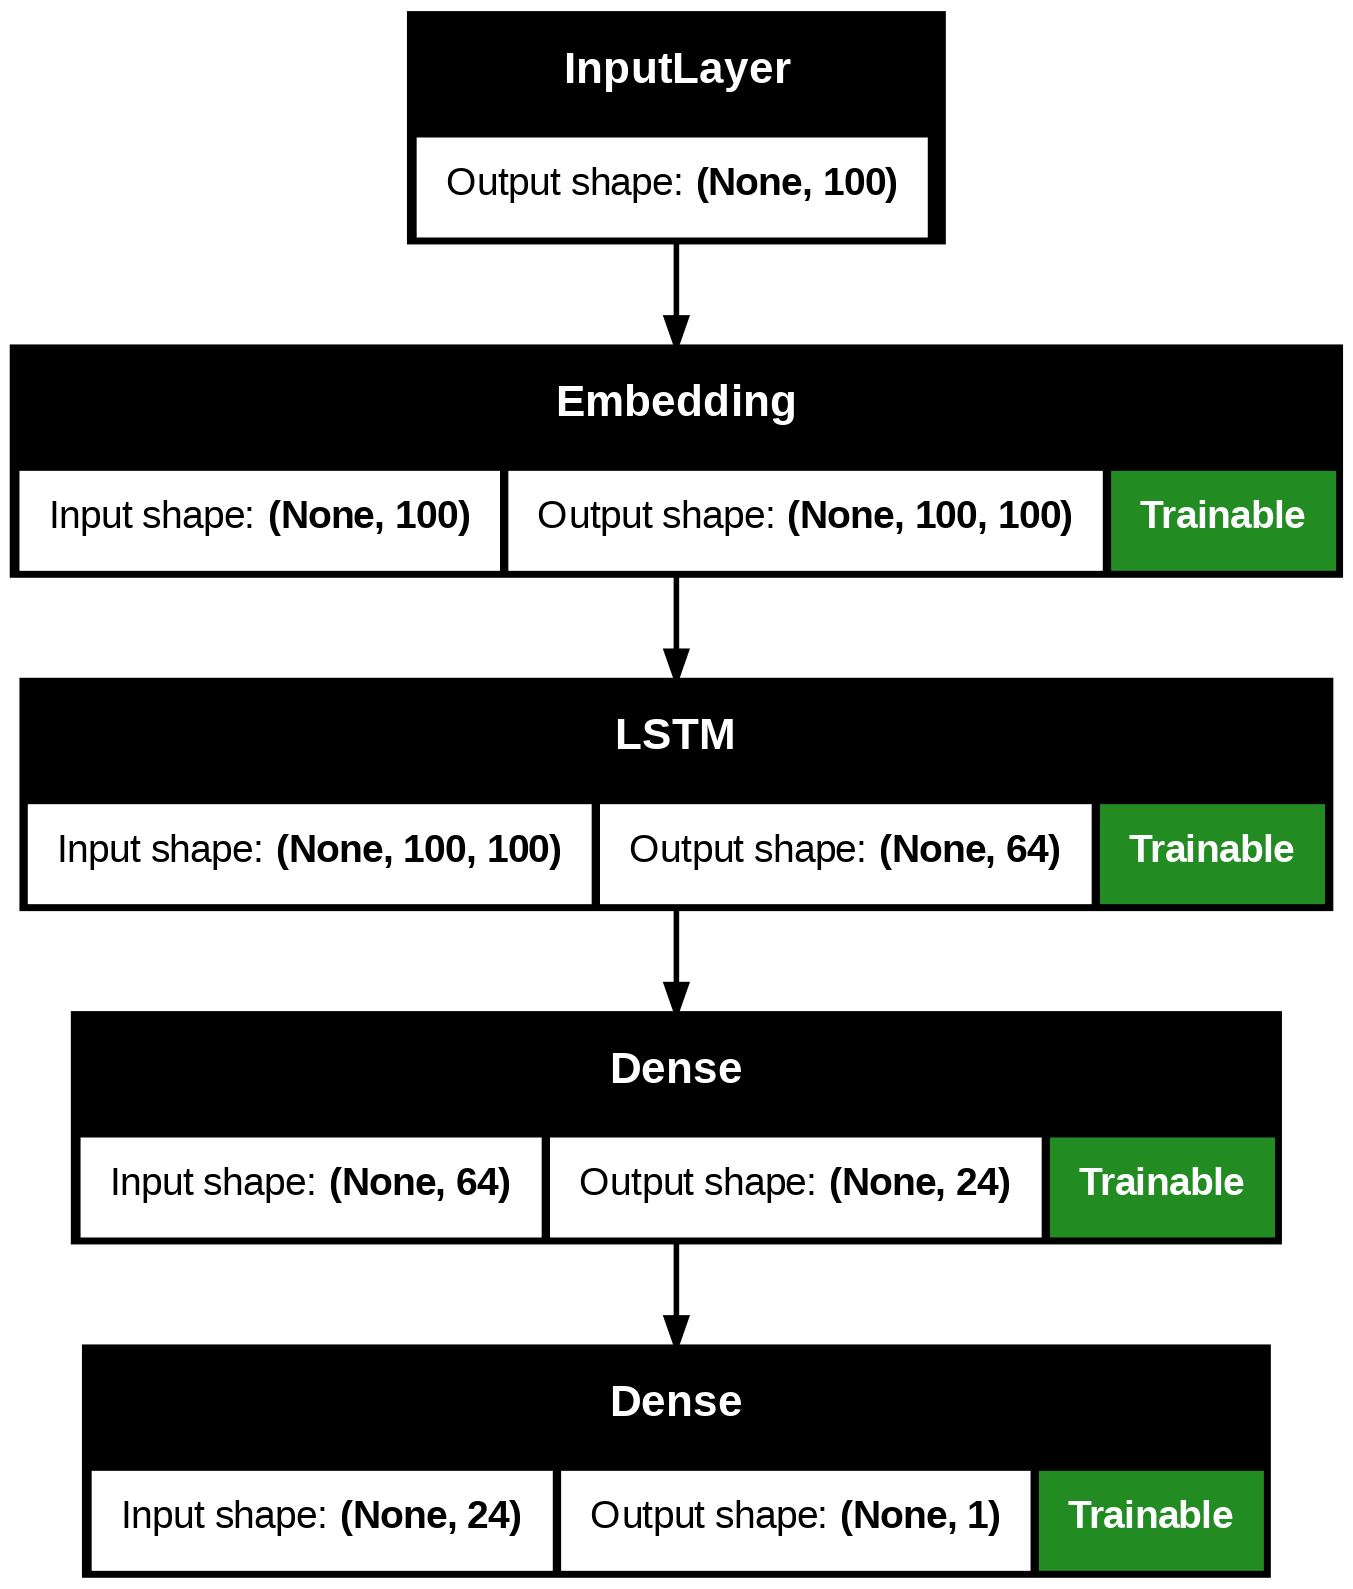

In [68]:
plot_model(model, show_shapes=True, show_trainable = True)

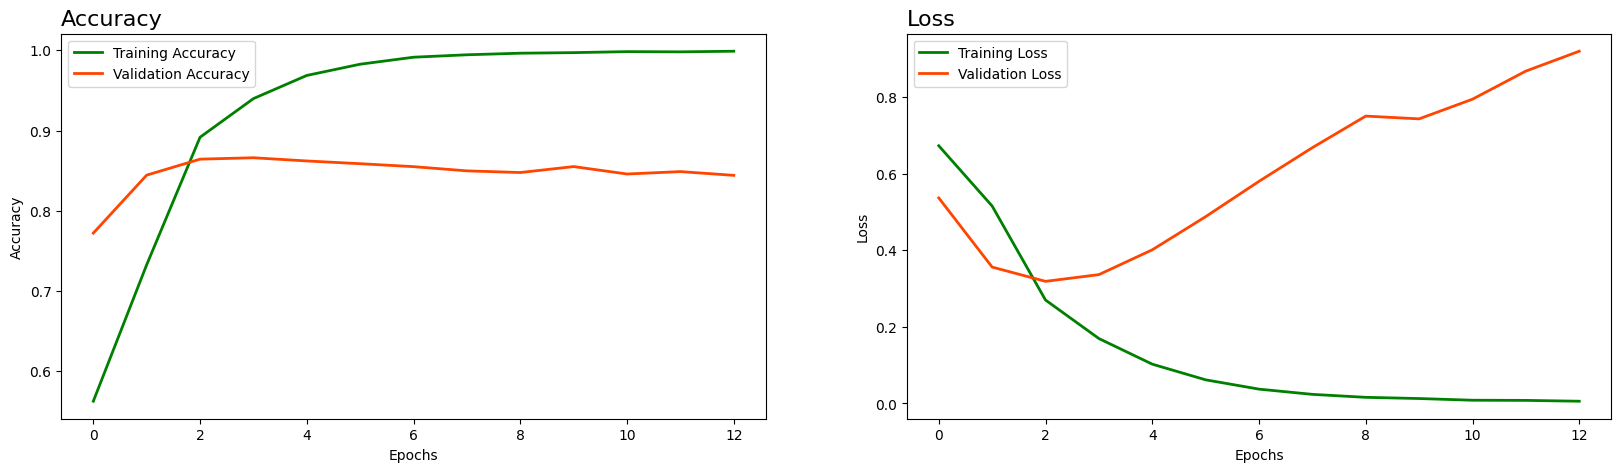

In [69]:
plot_history(history)

In [70]:
results = model.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8603 - loss: 0.3251


In [71]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [72]:
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      5000
           1       0.86      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# Build Bidirectional GRU/LSTM with Pretrained Embeddings - Glove

## Bidirectional LSTM

In [73]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze GloVe embeddings (set True for fine-tuning)
)(input_layer)

# Bidirectional LSTM layer
bilstm_layer = Bidirectional(LSTM(64))(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(bilstm_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the Functional model
blstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
blstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
blstm.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 24)                  │           3,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,087,701 (7.96 MB)

 Trainable params: 87,601 (342.19 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

In [74]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = blstm.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7083 - loss: 0.5472 - val_accuracy: 0.8036 - val_loss: 0.4483
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8186 - loss: 0.3986 - val_accuracy: 0.8321 - val_loss: 0.3813
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8433 - loss: 0.3572 - val_accuracy: 0.8303 - val_loss: 0.3751
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.8584 - loss: 0.3268 - val_accuracy: 0.8432 - val_loss: 0.3616
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8732 - loss: 0.2970 - val_accuracy: 0.8231 - val_loss: 0.4146
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8854 - loss: 0.2729 - val_accuracy: 0.8402 - val_loss: 0.3835
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9035 - loss: 0.2357 - val_accuracy: 0.8453 - val_loss: 0.3913
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9228 - loss: 0.1927 - 

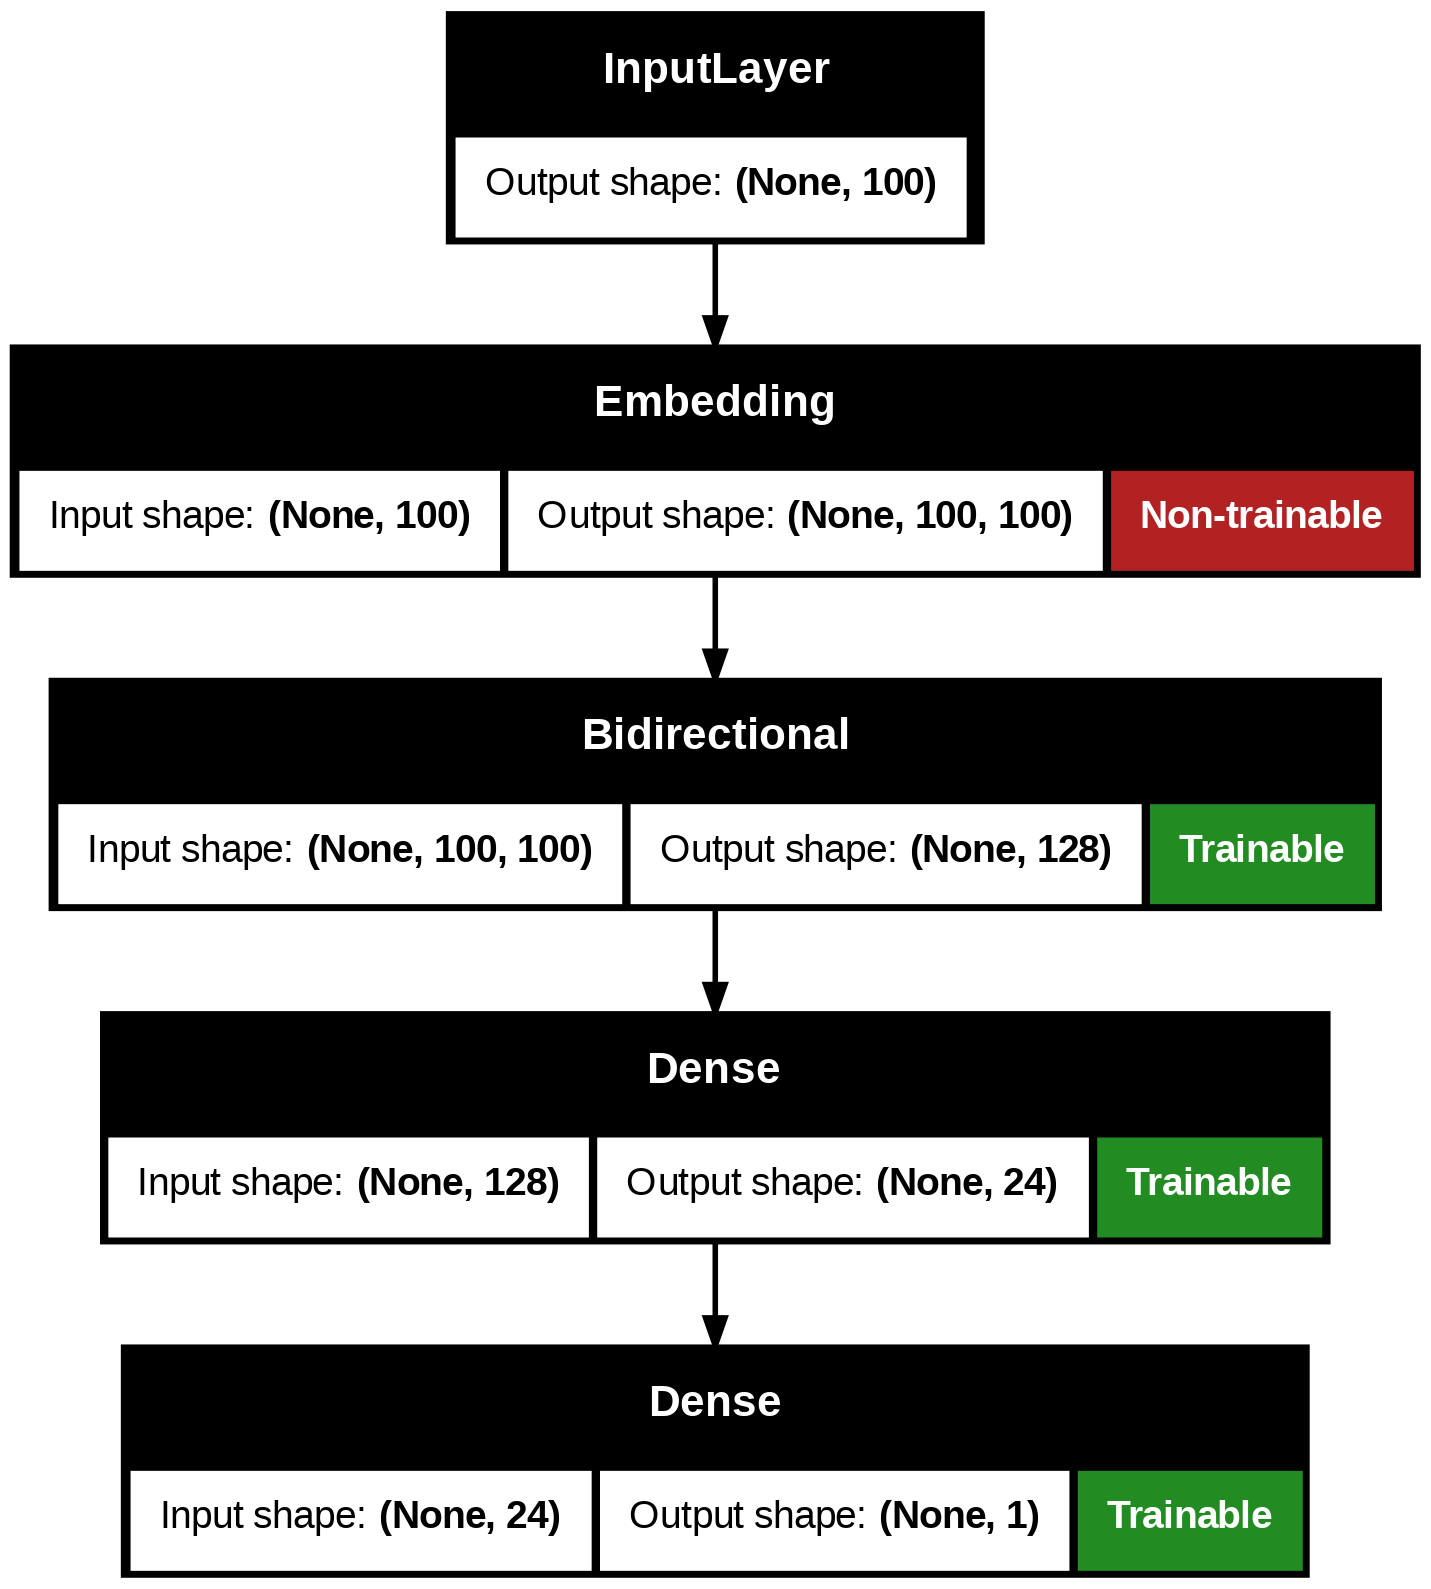

In [75]:
plot_model(blstm, show_shapes=True, show_trainable = True)

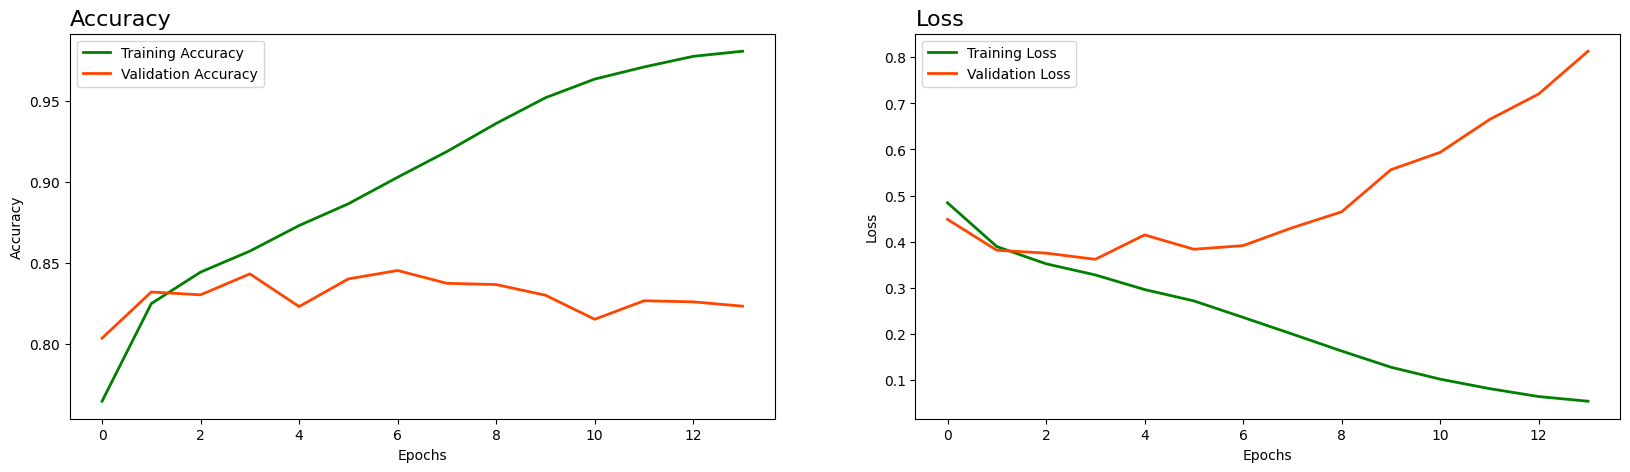

In [76]:
plot_history(history)

In [77]:
results = blstm.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8486 - loss: 0.3511


In [78]:
predictions = blstm.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [79]:
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5000
           1       0.83      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Bidrectional GRU

In [80]:
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

#  Define Input Layer
input_layer = Input(shape=(max_length,))  # Input is a sequence of word indices

# Embedding Layer with Pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (same as GloVe)
    input_length=max_length,        # Maximum sequence length
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Keep embeddings frozen (set True for fine-tuning)
)(input_layer)

#  Bidirectional GRU Layer
bigru_layer = Bidirectional(GRU(64))(embedding_layer)

#  Fully Connected Layers
dense_layer = Dense(24, activation='relu')(bigru_layer)

#  Output Layer for Binary Classification
output_layer = Dense(1, activation='sigmoid')(dense_layer)

#  Define the Functional Model
bigru_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#  Compile the Model
bigru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Print Model Summary
bigru_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          63,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 24)                  │           3,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,066,965 (7.88 MB)

 Trainable params: 66,865 (261.19 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

In [81]:
#fit model
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = bigru_model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6980 - loss: 0.5519 - val_accuracy: 0.7856 - val_loss: 0.4511
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8360 - loss: 0.3707 - val_accuracy: 0.8361 - val_loss: 0.3692
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8516 - loss: 0.3362 - val_accuracy: 0.8401 - val_loss: 0.3601
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8666 - loss: 0.3104 - val_accuracy: 0.8407 - val_loss: 0.3632
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8866 - loss: 0.2760 - val_accuracy: 0.8490 - val_loss: 0.3573
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8980 - loss: 0.2463 - val_accuracy: 0.8420 - val_loss: 0.3676
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9171 - loss: 0.2071 - val_accuracy: 0.8428 - val_loss: 0.4000
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9364 - loss: 0.1650 - 

In [82]:
predictions = bigru_model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5000
           1       0.84      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Bidirectional LSTM - Hidden State Element Wise Mean

In [83]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, GlobalAveragePooling1D

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define Input Layer
input_layer = Input(shape=(max_length,))  # Input is a sequence of word indices

#  Embedding Layer with Pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (same as GloVe)
    input_length=max_length,        # Maximum sequence length
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Keep embeddings frozen (set True for fine-tuning)
)(input_layer)

#  Bidirectional LSTM Layer (return_sequences=True to retain all hidden states)
bilstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Compute Element-wise Mean of All Hidden States
mean_hidden_states = GlobalAveragePooling1D()(bilstm_layer)

# Fully Connected Layer
dense_layer = Dense(24, activation='relu')(mean_hidden_states)

# Output Layer for Binary Classification
output_layer = Dense(1, activation='sigmoid')(dense_layer)

#  Define the Functional Model
blstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#   Compile the Model
blstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print Model Summary
blstm.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, 100, 100)            │       2,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 24)                  │           3,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,087,701 (7.96 MB)

 Trainable params: 87,601 (342.19 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

In [ ]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = blstm.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7335 - loss: 0.5291 - val_accuracy: 0.8125 - val_loss: 0.4121
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8242 - loss: 0.3949 - val_accuracy: 0.8235 - val_loss: 0.3863
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8475 - loss: 0.3517 - val_accuracy: 0.8424 - val_loss: 0.3628
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8562 - loss: 0.3276 - val_accuracy: 0.8402 - val_loss: 0.3638
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8726 - loss: 0.3008 - val_accuracy: 0.8476 - val_loss: 0.3496
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8823 - loss: 0.2779 - val_accuracy: 0.8462 - val_loss: 0.3508
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8995 - loss: 0.2452 - val_accuracy: 0.8515 - val_loss: 0.3656
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9146 - loss: 0.2115 - 

In [ ]:
plot_model(blstm, show_shapes=True, show_trainable = True)

In [ ]:
plot_history(history)

In [ ]:
predictions = blstm.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

## Bidirectional GRU - Hidden State Element Wise Mean

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense, GlobalAveragePooling1D

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

#  Define Input Layer
input_layer = Input(shape=(max_length,))  # Input is a sequence of word indices

#  Embedding Layer with Pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (same as GloVe)
    input_length=max_length,        # Maximum sequence length
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Keep embeddings frozen (set True for fine-tuning)
)(input_layer)

#  Bidirectional GRU Layer (return_sequences=True to retain all hidden states)
bigru_layer = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)

# Compute Element-wise Mean of All Hidden States
mean_hidden_states = GlobalAveragePooling1D()(bigru_layer)

#  Fully Connected Layer
dense_layer = Dense(24, activation='relu')(mean_hidden_states)

#  Output Layer for Binary Classification
output_layer = Dense(1, activation='sigmoid')(dense_layer)

#  Define the Functional Model
bigru_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#  Compile the Model
bigru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Print Model Summary
bigru_model.summary()


In [ ]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = bigru_model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

In [ ]:
predictions = bigru_model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

## Bidirectional LSTM - Concatenation

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze GloVe embeddings (set True for fine-tuning)
)(input_layer)

# First Bidirectional LSTM Layer (returning sequences)
bilstm_layer_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Second Bidirectional LSTM Layer (last layer outputs a single vector)
bilstm_layer_2 = Bidirectional(LSTM(32))(bilstm_layer_1)

# Fully connected layer
dense_layer = Dense(64, activation='relu')(bilstm_layer_2)
dropout_layer = Dropout(0.5)(dense_layer)  # Dropout to reduce overfitting
output_layer = Dense(1, activation='sigmoid')(dropout_layer)  # Binary classification output

# Define the Functional model
blstmc = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
blstmc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
blstmc.summary()

In [ ]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = blstmc.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

In [ ]:
plot_model(blstmc, show_shapes=True, show_trainable = True)

In [ ]:
plot_history(history)

In [ ]:
results = blstmc.evaluate(test_padded, test_labels, verbose=1)

In [ ]:
predictions = blstmc.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)

In [ ]:
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

## Bidirectional GRU - Concatenation

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

#  Define Input Layer
input_layer = Input(shape=(max_length,))  # Input is a sequence of word indices

# Embedding Layer with Pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (same as GloVe)
    input_length=max_length,        # Maximum sequence length
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Keep embeddings frozen (set True for fine-tuning)
)(input_layer)

#  First Bidirectional GRU Layer (returning sequences)
bigru_layer_1 = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)

#  Second Bidirectional GRU Layer (outputs a single vector)
bigru_layer_2 = Bidirectional(GRU(32))(bigru_layer_1)

# Fully Connected Layers
dense_layer = Dense(64, activation='relu')(bigru_layer_2)
dropout_layer = Dropout(0.5)(dense_layer)  # Dropout to reduce overfitting

# Output Layer for Binary Classification
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Define the Functional Model
bigru_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#  Compile the Model
bigru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Print Model Summary
bigru_model.summary()


In [ ]:
#fit model
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = bigru_model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

In [ ]:
predictions = bigru_model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

## End of the code

In [ ]:
!pip install -q jupyter
!pip install -q nbconvert

In [ ]:
!jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/Recurrent_Neural_Nets_LSTM_and_GRU_Colab.ipynb" --to html